# Úkol č. 3 - Segmentace zákazníků e-shopu
**Deadline úkolu je uveden na [course pages](https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html).**

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu, která jsou v přiloženém souboru `eshop.csv`.

## Pokyny k vypracování

Ve všech bodech zadání uvažujte aktuální datum jako datum poslední transakce (19. 12. 2015), nikoliv dnešek. Tváříme se, že jde o aktuální data.

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

### Načtení knihoven
* před začátkem práce si importuji veškeré knihovny, které dále v textu použiji

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

np.set_printoptions(precision=5, suppress=True)  # potlačení výpisu floatů (tak aby 0.000 bylo zobrazeno jako 0.)

pd.options.mode.chained_assignment = None # potlaceni nechtenych upozorneni

### Načtení dat ze souboru

In [2]:
# nacteni csv souboru
cstmr = pd.read_csv("eshop.csv")

# doplnujici informace k datum, jejich tvar, ukazka atd..
print("|dataset eshop.csv|")
print("----------------------------------------------")
print("\n|dataset head|")
display(cstmr.head())
print("----------------------------------------------")
print("\n|dataset shape|")
display(cstmr.shape)
print("----------------------------------------------")
print("\n|dataset info|")
display(cstmr.info())
print("----------------------------------------------")
print("\n|dataset nunique|")
display(cstmr.nunique())

|dataset eshop.csv|
----------------------------------------------

|dataset head|


,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


----------------------------------------------

|dataset shape|


(22408, 4)

----------------------------------------------

|dataset info|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22408 entries, 0 to 22407
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  22408 non-null  int64  
 1   Date         22408 non-null  object 
 2   Subtotal     22408 non-null  float64
 3   Country      22405 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 700.4+ KB


None

----------------------------------------------

|dataset nunique|


Customer ID    12829
Date            2734
Subtotal        8951
Country           42
dtype: int64

### Prvotní předzracování dat
* Před prací s daty si je nejdříve musím načíst
* To provedu pomocí rozdělení si množiny dat na dvě části
* V první first_half si sečtu sloupec s cenou nákupu jednotlivých zákazníků a k tomu si sečtu počet nákupů zákazníka, které se nachází v datasetu
* V druhé second_half si ukládám pouze poslední nákup a z něho následně vypočítám počet dní ke dni 19.12.2015
* Nakonec si tyto datasety spojím do jednoho a vypíši informace o něm

In [3]:
#rfm processing
#get Frequency and Monetary
first_half  = cstmr.groupby(cstmr['Customer ID'])['Subtotal'].agg(['sum','count'])#.reset_index()
#rename columns
first_half  = first_half.rename(columns={'sum': 'monetary', 'count': 'frequency'})

#get Recency
second_half = cstmr
second_half.drop_duplicates(subset=['Customer ID'], keep='last', inplace=True)
second_half = second_half[['Customer ID', 'Date']]

#set current day
current_day = pd.to_datetime('12/19/2015')

#calculate the number of days
second_half['recency'] = current_day - pd.to_datetime(second_half['Date'])
second_half['recency'] = second_half['recency'].apply(lambda x: x.days)
second_half = second_half[['Customer ID', 'recency']]

#merge together
dts = first_half.join(second_half.set_index('Customer ID'), on='Customer ID')

print("New datasets shape")
display(dts.shape)
print("----------------------------------------------")
print("\n|new dataset head|")
display(dts.head())
print("----------------------------------------------")
print("\n|new dataset info|")
# display(dts.info())

New datasets shape


(12829, 3)

----------------------------------------------

|new dataset head|


,monetary,frequency,recency
Customer ID,,,
7,15.54,3,311
9,13.20,1,3050
30,36.20,1,3025
34,86.00,1,3103
38,38.40,1,3097


----------------------------------------------

|new dataset info|


### Grafické zobrazení vytvořeného datasetu
* Po vytvoření datasetu si jej prohlednu, jelikož se jedná o data zobrazitelná ve 3D prostoru, lze je zobrazit v grafu
* Pořadí sloupečků si u zobrazování prohodím, abych získal lepší grafickou prezentaci

Int64Index([    7,     9,    30,    34,    38,    41,    47,    48,    53,
               61,
            ...
            15351, 15352, 15353, 15354, 15355, 15356, 15357, 15358, 15359,
            15360],
           dtype='int64', name='Customer ID', length=12829)

---------------------------------------------


array([[  15.54,    3.  ,  311.  ],
       [  13.2 ,    1.  , 3050.  ],
       [  36.2 ,    1.  , 3025.  ],
       ...,
       [ 153.23,    1.  ,    1.  ],
       [  19.15,    1.  ,    0.  ],
       [ 139.1 ,    1.  ,    0.  ]])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


---------------------------------------------


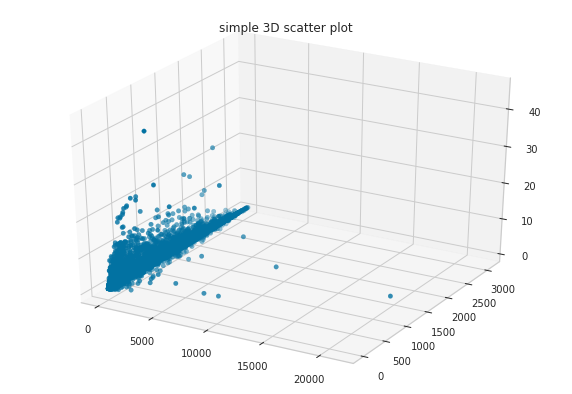

In [4]:
display(dts.index)
print("---------------------------------------------")
display(dts.values)
print("---------------------------------------------")

#transforming dataset
X = dts.values.astype(float)

# creating figure
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')

# creating plot
ax.scatter3D(X[:,0], X[:,2], X[:,1])
plt.title('simple 3D scatter plot')

# show plot
plt.show()

### Nalezení nejlepšího počtu shluků
* Toto provedu pomocí dvou přístupů
* Nejprve bez použití knihovny

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


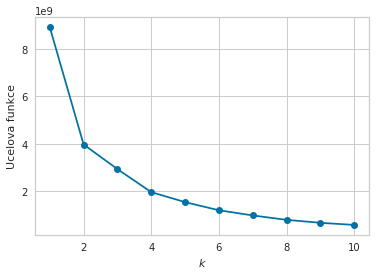

In [5]:
#kmeans
ix = np.zeros(10)
iy = np.zeros(10)

#prohledavani od 1 do 10
for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state = 1, init='k-means++')
    kmeans.fit(X)
    iy[k] = kmeans.inertia_
    ix[k] = k+1

# show plot
plt.show()

plt.xlabel('$k$')
plt.ylabel('Ucelova funkce')
plt.plot(ix, iy, 'o-')
plt.show()

* Následně pomocí knihovny yellowbrick, která nám sama řekne po správném použití, jaký počet shluků je optimální

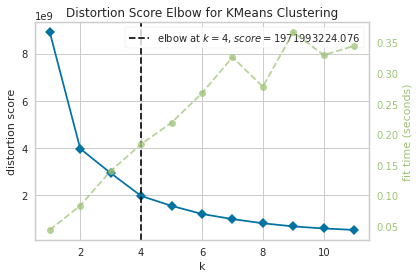

In [6]:
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Výpočet shluků
* Po získání všech potřebných informací a dat lze nad datasetem spustit algoritmus k-means
* Do vstupu algoritmu jsem doplnil n_clusters, tedy počet shluků získáných v předchozím kroku a další potřebné paramety

In [7]:
km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=1000, random_state=0)

# get the clusters
y_kmeans = km.fit_predict(X)

# get the centers of clusters
centers = kmeans.cluster_centers_

# inform me, when it is done
print("done")

done


### Grafická prezentace získaných shluků
* Nejdříve si nastavím vše potřebné pro vykreslení grafu a následně zadám data z algoritmu k-means, ty jsou uložena v y_kmeans, jedná se o informaci, do jakého shluku jednotlivá data náleží

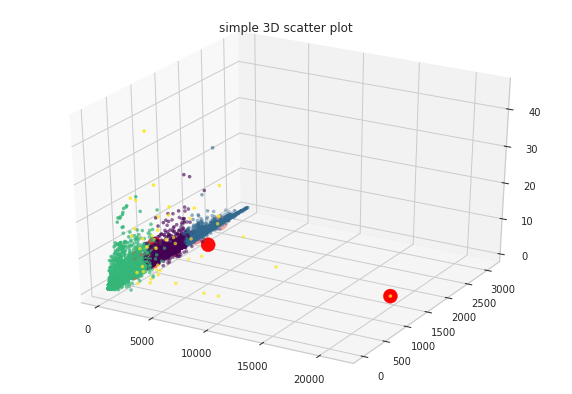

In [8]:
# creating figure
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')

# creating plot
ax.scatter3D(centers[:,0], centers[:,2], centers[:,1], s=200, c='red')

ax.scatter3D(X[:,0], X[:,2], X[:,1], c=y_kmeans, s=10, cmap='viridis')
plt.title('simple 3D scatter plot')

# show plot
plt.show()

### Opakované předzpracování dat
* Než vykonám nějaké závěry nad daty a jak s nimi naložit, jak je upravit, tak si musím zobrazit doplňující informace k nim
* Jelikož v datech máme celkem tři údaje recency, frequency a monetary a každé z nich jsou v jiných jednotkách, reprezentují rozdílně věci a díky tomu jsou v jednotlivých dimenzích jsou jednotlivé body rozdílně blízko od sebe
* Pro lepší výsledky algoritmu k-means je třeba tuto rozdílnost snížit, odstranit
* K tomu jsem použil dvě věci, první je škálování, standartizace a druhou je normalizace. Avšak po použití normalizace, ať už ser jednalo o l1, l2 nebo max jsem dostával výsledky, které sice byly optimální z hlediska Silhouette analýzi, ale výsledky nebyly natolik dobré.
* Po vyzkoušení Standartního škálování, MinMax škálování, MaxAbs škálování a Robust škálování se ukázalo Standartní jako to nejlepší. Proto jej zde nadále používám.

In [9]:
# columns info
print("|describe monetary|")
display(dts['monetary'].describe())
print("----------------------------------------------")
print("|describe frequency|")
display(dts['frequency'].describe())
print("----------------------------------------------")
print("|describe recency|")
display(dts['recency'].describe())

|describe monetary|


count    12829.000000
mean       155.806657
std        407.744435
min          1.180000
25%         32.040000
50%         64.810000
75%        143.510000
max      21392.380000
Name: monetary, dtype: float64

----------------------------------------------
|describe frequency|


count    12829.000000
mean         1.746668
std          2.010044
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         45.000000
Name: frequency, dtype: float64

----------------------------------------------
|describe recency|


count    12829.000000
mean      1102.619690
std        726.546225
min          0.000000
25%        456.000000
50%       1062.000000
75%       1681.000000
max       3103.000000
Name: recency, dtype: float64

In [10]:
#scaling
# zde jsem sám vypočítával minmax škálování
# dts['scl_monetary']  = (dts['monetary'] - 1.18)/(21392.38 - 1.18)
# dts['scl_frequency'] = (dts['frequency'] - 1)/(45 - 1)+10
# dts['scl_recency']   = (dts['recency'] - 0)/(3103 - 0)
# display(dts)

* Po aplikaci Standardního škálování si výsledek zobrazuji

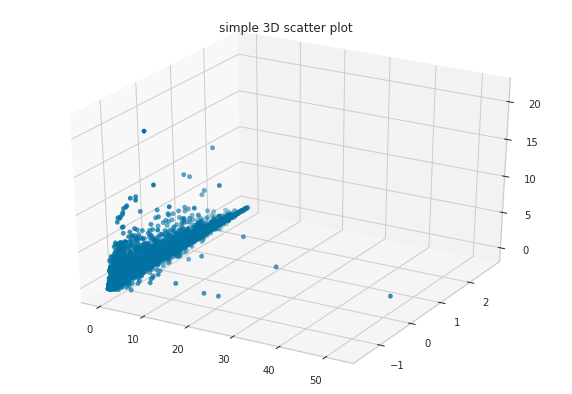

In [11]:
#transforming dataset
# creating figure
figg = plt.figure(figsize=(10,7))
axg = plt.axes(projection='3d')

X_sc = prep.StandardScaler().fit(dts).transform(dts)

#X_sc = prep.normalize(X_sc, norm='l2') #prep.MinMaxScaler().fit(dts).transform(dts)

# creating plot
axg.scatter3D(X_sc[:,0], X_sc[:,2], X_sc[:,1])
plt.title('simple 3D scatter plot')

# show plot
plt.show()

In [12]:
# zde je pouze mnou testovane normalizace a skalovani nad casti dat
display(prep.MinMaxScaler().fit(X_sc[:,[0,2]]).transform(X_sc[:,[0,2]]))

display(prep.normalize(X_sc[:,[0,2]]))

array([[0.00067, 0.10023],
       [0.00056, 0.98292],
       [0.00164, 0.97486],
       ...,
       [0.00711, 0.00032],
       [0.00084, 0.     ],
       [0.00645, 0.     ]])

array([[-0.30108, -0.9536 ],
       [-0.12939,  0.99159],
       [-0.11019,  0.99391],
       ...,
       [-0.00417, -0.99999],
       [-0.21565, -0.97647],
       [-0.02699, -0.99964]])

* Opět testuji data jaký počet shluků mám vybrat a použít

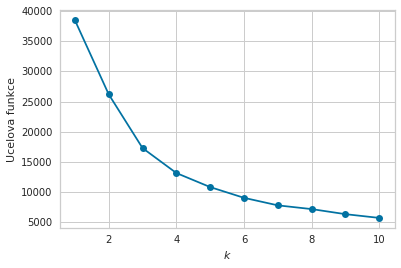

In [13]:
#kmeans
ix = np.zeros(10)
iy = np.zeros(10)
for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state = 1)
    kmeans.fit(X_sc)
    iy[k] = kmeans.inertia_
    ix[k] = k+1

# show plot
plt.show()

plt.xlabel('$k$')
plt.ylabel('Ucelova funkce')
plt.plot(ix, iy, 'o-')
plt.show()

* Opět používám knihovnu na ověření získaného počtu shluků

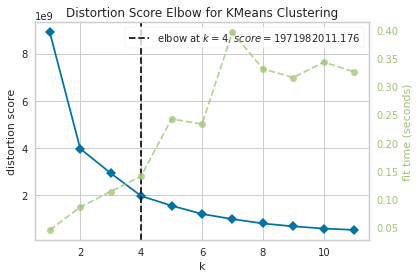

In [14]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Finální výpočet shluků
* Po úpravě dat, přeškálování a ověření nutného použití shluků znova provádím vypočet spuštením funkce z knihovny

In [15]:
# run kmeans
km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=1000, random_state=0)
# get result
y_kmeans = km.fit_predict(X_sc)
# get centers
centers = kmeans.cluster_centers_
print("done")

done


 * Po získání výsledku si data opět zobrazím, oddělané barvami dle toho do jakého shluku patří

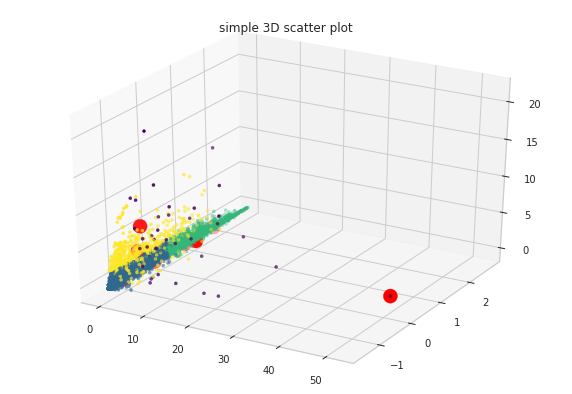

In [16]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')

# creating plot
ax.scatter3D(centers[:,0], centers[:, 2], centers[:,1], s=200, c='red')

ax.scatter3D(X_sc[:,0], X_sc[:,2], X_sc[:,1], c=y_kmeans, s=10, cmap='viridis')
plt.title('simple 3D scatter plot')

# show plot
plt.show()

In [17]:
# ulozeni vysledku nalezitosti k shluku k jednotlivym zaznamum
dts['sector'] = y_kmeans

### Vyhodnocení výsledku
* Po všech operacích nad daty a získání finálních shluků si jednotlivé zobrazím, a dle kvality
* Požadovaným kvalitám, vysoká monetary, vysoká frequency a nízká recency odpovídá jediný shluk a to shluk 0, neobsahuje žádné nulové monetary a ostatní hodnoty jsou v rámci mezí shodné se zadáním. Tento shluk se dal najít i pomocí vybraného zákazníka, který měl nejvyšší monetary a díky tomu i nenízký frequency.

Nejlepší shluk


,monetary,frequency,recency,sector
Customer ID,,,,
216,2614.37,19,32,0
582,3669.14,45,72,0
2074,2154.51,28,1830,0
2449,5020.96,13,1230,0
2482,4605.18,32,9,0
2651,2845.71,18,691,0
2777,2345.95,27,32,0
2872,3863.01,16,142,0
3160,3562.44,10,479,0


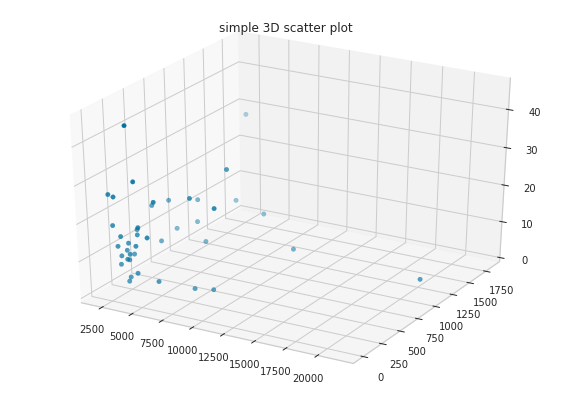

-------------------------------------------


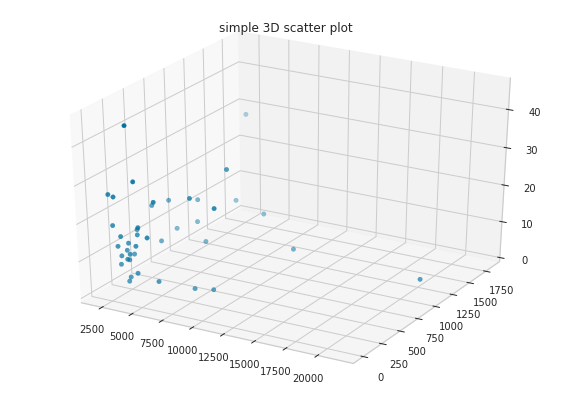

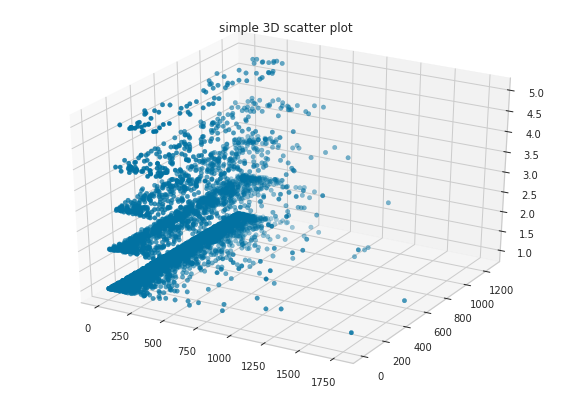

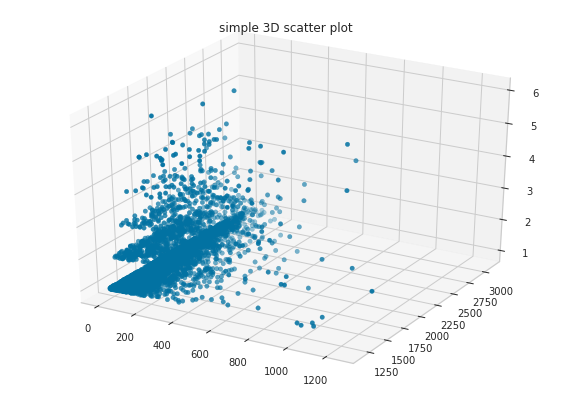

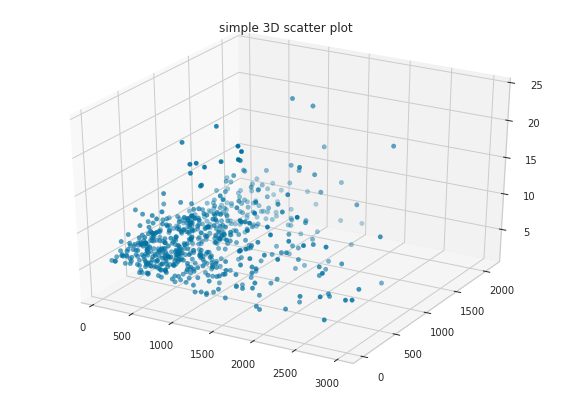

In [18]:
print("Nejlepší shluk")
superStars  = dts[dts.sector == 0].values
display(dts[dts.sector==0])

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')

ax.scatter3D(superStars[:,0], superStars[:,2], superStars[:,1])
plt.title('simple 3D scatter plot')

# show plot
plt.show()

print("-------------------------------------------")
for i in range(4):
    superStars  = dts[dts.sector == i].values

    fig = plt.figure(figsize=(10,7))
    ax = plt.axes(projection='3d')

    ax.scatter3D(superStars[:,0], superStars[:,2], superStars[:,1])
    plt.title('simple 3D scatter plot')

    # show plot
    plt.show()

### Analýza vytvořených shluků pomocí metody silhouette
* Pro analýzu využívám funkci SilhouetteVisualizer z knihovny yellowbrick
* Nejdříve vložím vytvořený naučený kmeans model a následně spouštím naučení se nad daty použitých v modelu
* Ve výsledku dostávám informaci o tom, že můj model je na hranici suboptimality, hodnota je lehce pod 0.5 a velikost jednotlivých shluků je rozdílná. dva z nich jsou menší než ostatní.
* Jak získat lepší výsledky? Použitím normalizace, kterou jsem zmiňoval dříve se výsledky dostávají na optimální výšiny, avšak pro tyto data jsem tento přístup nepoužil.
* A to z jednoho důvodu, vyvážením shluků sice přinese lepší výsledky v silhouette analýze, ale podstatně horší v získávání nejlepších zákazníků

/home/dave/.local/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd243bd2a60>,
                     colors='yellowbrick', is_fitted='auto', model=None)

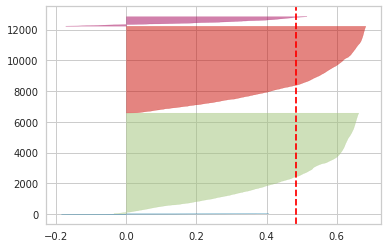

In [19]:
# silhouette analysis
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(X_sc)